In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data = pd.read_csv("/content/Admission_Predict_A3.csv")


In [3]:
s=data.describe(percentiles=[])
s.rename(index={'50%':'Median'},inplace=True)

print(s)

        Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count   500.000000  500.000000   500.000000         500.000000  500.000000   
mean    250.500000  316.472000   107.192000           3.114000    3.374000   
std     144.481833   11.295148     6.081868           1.143512    0.991004   
min       1.000000  290.000000    92.000000           1.000000    1.000000   
Median  250.500000  317.000000   107.000000           3.000000    3.500000   
max     500.000000  340.000000   120.000000           5.000000    5.000000   

             LOR         CGPA    Research  Chance of Admit   
count   500.00000  500.000000  500.000000         500.00000  
mean      3.48400    8.576440    0.560000           0.72174  
std       0.92545    0.604813    0.496884           0.14114  
min       1.00000    6.800000    0.000000           0.34000  
Median    3.50000    8.560000    1.000000           0.72000  
max       5.00000    9.920000    1.000000           0.97000  


In [4]:
missing_values = data.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0]
print(columns_with_missing_values)

Series([], dtype: int64)


In [5]:
# Check for duplicate rows
duplicates = data.duplicated()

if duplicates.sum() > 0:
    print(f"Found {duplicates.sum()} duplicate rows.")
else:
    print("No duplicate rows found.")

# Optional: Drop duplicates if needed
data = data.drop_duplicates()


No duplicate rows found.


In [6]:
from scipy.stats import zscore

# Calculate Z-scores for each feature
z_scores = np.abs(zscore(data.iloc[:, :-1]))  # Exclude target column

# Identify rows with any Z-score greater than 3 (common threshold)
outliers = np.where(z_scores > 3)

print(f"Number of outliers detected: {len(outliers[0])}")

# IQR Method to detect outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
print(f"Outliers found in each column:\n{outliers.sum()}")



Number of outliers detected: 0
Outliers found in each column:
Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  1
CGPA                 0
Research             0
Chance of Admit      2
dtype: int64


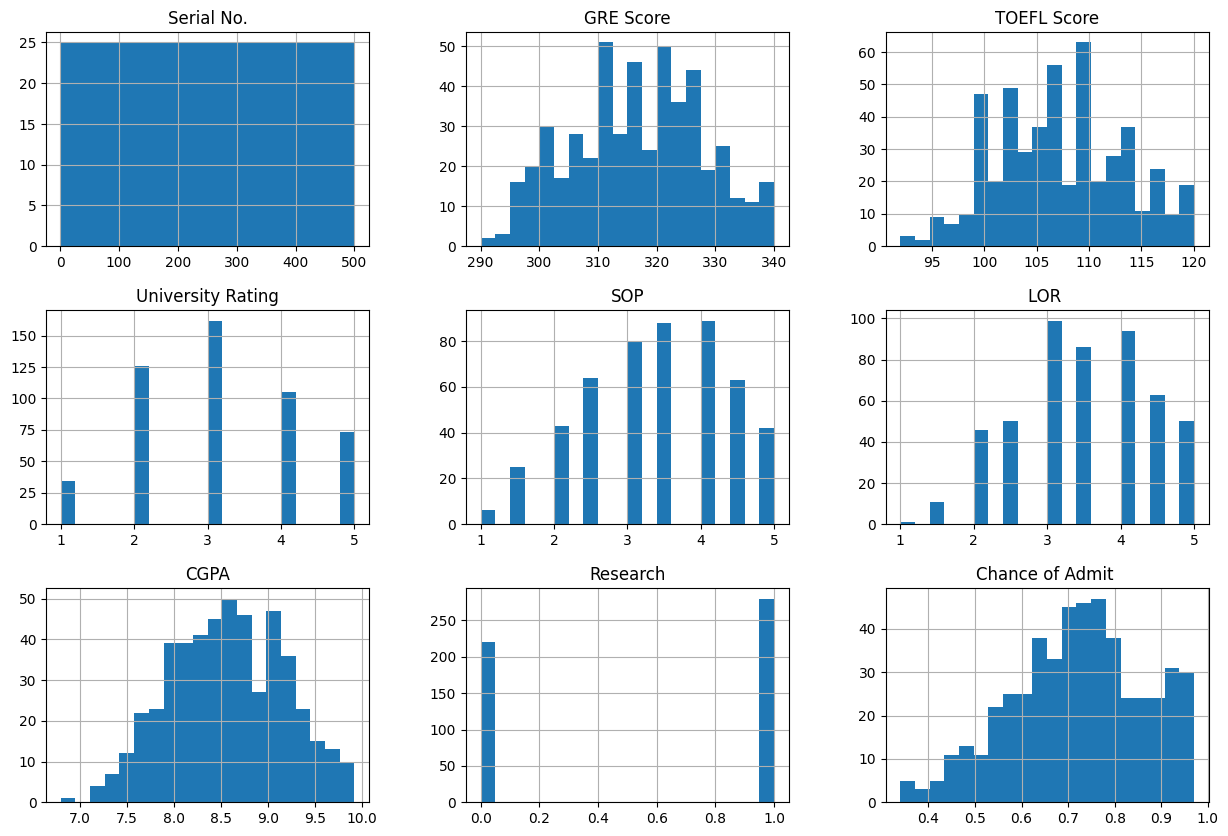

In [7]:
data.hist(bins=20, figsize=(15, 10))
plt.show()


In [8]:

from sklearn.preprocessing import StandardScaler

cols_to_normalize = data.columns.difference(['Chance of Admit'])

# Apply normalization to selected columns
data[cols_to_normalize] = (data[cols_to_normalize] - data[cols_to_normalize].min()) / (data[cols_to_normalize].max() - data[cols_to_normalize].min())

In [9]:
s=data.describe(percentiles=[])
s.rename(index={'50%':'Median'},inplace=True)

print(s)

        Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count   500.000000  500.000000   500.000000         500.000000  500.000000   
mean      0.500000    0.529440     0.542571           0.528500    0.593500   
std       0.289543    0.225903     0.217210           0.285878    0.247751   
min       0.000000    0.000000     0.000000           0.000000    0.000000   
Median    0.500000    0.540000     0.535714           0.500000    0.625000   
max       1.000000    1.000000     1.000000           1.000000    1.000000   

              LOR         CGPA    Research  Chance of Admit   
count   500.000000  500.000000  500.000000        500.000000  
mean      0.621000    0.569372    0.560000          0.605937  
std       0.231362    0.193850    0.496884          0.224032  
min       0.000000    0.000000    0.000000          0.000000  
Median    0.625000    0.564103    1.000000          0.603175  
max       1.000000    1.000000    1.000000          1.000000  


TASK 3

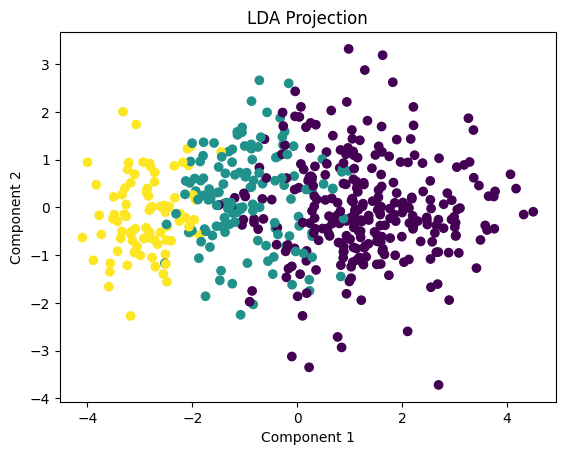

In [10]:

bins = [0, 0.65, 0.85, 1]
labels = ['low', 'medium', 'high']

data['AdmitCategory'] = pd.cut(data['Chance of Admit '], bins=bins, labels=labels)

data = data.dropna(subset=['AdmitCategory'])

X = data.drop(['Chance of Admit ', 'AdmitCategory'], axis=1)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


# Apply LDA
lda = LDA(n_components=2)  # Adjust the number of components as needed
X_lda = lda.fit_transform(X_imputed, data['AdmitCategory'])

# Visualize LDA output
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=data['AdmitCategory'].cat.codes)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('LDA Projection')
plt.show()

TASK 4

Epoch 0, Loss: 3.031623363494873
Epoch 100, Loss: 0.07031605392694473
Epoch 200, Loss: 0.04918685555458069
Epoch 300, Loss: 0.04881741479039192
Epoch 400, Loss: 0.04881095513701439
Epoch 500, Loss: 0.048810843378305435
Epoch 600, Loss: 0.04881083220243454
Epoch 700, Loss: 0.048810843378305435
Epoch 800, Loss: 0.048810843378305435
Epoch 900, Loss: 0.04881083965301514


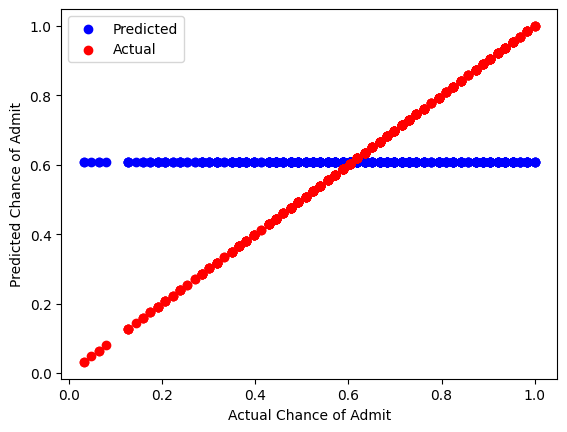

In [11]:

# Convert LDA-transformed data into TensorFlow tensors
X_tensor = tf.convert_to_tensor(X_lda, dtype=tf.float32)
y_tensor = tf.convert_to_tensor(data['Chance of Admit '].values, dtype=tf.float32)

# Initialize weights and biases
weights = tf.Variable(tf.random.normal([X_tensor.shape[1], 1]))
biases = tf.Variable(tf.random.normal([1]))

# Define the linear regression model
def linear_regression(X):
    return tf.add(tf.matmul(X, weights), biases)

# Define Mean Squared Error (MSE) as the loss function
def compute_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true))

# Set up the optimizer (Stochastic Gradient Descent with a learning rate of 0.01)
optimizer = tf.optimizers.SGD(learning_rate=0.01)

# Training loop for 1000 epochs
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred = linear_regression(X_tensor)
        loss = compute_loss(y_pred, y_tensor)

    # Compute gradients and update weights and biases
    gradients = tape.gradient(loss, [weights, biases])
    optimizer.apply_gradients(zip(gradients, [weights, biases]))

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# Final predicted values
y_pred = linear_regression(X_tensor).numpy()

# Visualize the actual vs. predicted labels
import matplotlib.pyplot as plt
plt.scatter(data['Chance of Admit '], y_pred, color='blue', label='Predicted')
plt.scatter(data['Chance of Admit '],data['Chance of Admit '], color='red', label='Actual')
plt.xlabel('Actual Chance of Admit')
plt.ylabel('Predicted Chance of Admit')
plt.legend()
plt.show()


Mean Squared Error (Scikit-Learn): 0.00858169505448249


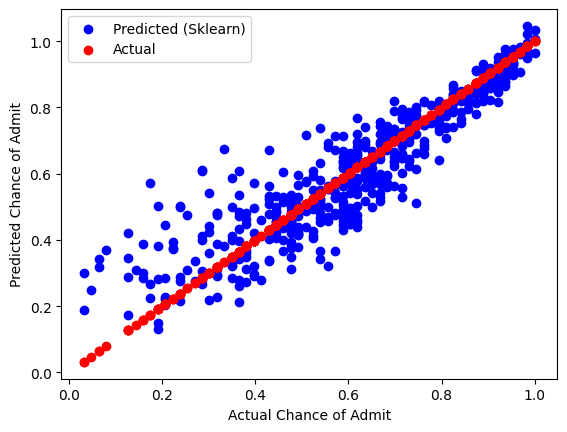

In [12]:


# Initialize the linear regression model
regressor = LinearRegression()

# Fit the model using the LDA-transformed features and the original "Chance of Admit" values
regressor.fit(X_lda,data['Chance of Admit '])

# Predict using the model
y_pred_sklearn = regressor.predict(X_lda)

# Evaluate the model performance
mse = mean_squared_error(data['Chance of Admit '], y_pred_sklearn)
print(f'Mean Squared Error (Scikit-Learn): {mse}')

# Visualize the actual vs. predicted labels
plt.scatter(data['Chance of Admit '], y_pred_sklearn, color='blue', label='Predicted (Sklearn)')
plt.scatter(data['Chance of Admit '], data['Chance of Admit '], color='red', label='Actual')
plt.xlabel('Actual Chance of Admit')
plt.ylabel('Predicted Chance of Admit')
plt.legend()
plt.show()


TASK 5

In [13]:

# Convert the "Chance of Admit" into three categories: low, medium, high
bins = [0, 0.65, 0.85, 1]
labels = ['low', 'medium', 'high']
data['AdmitCategory'] = pd.cut(data['Chance of Admit '], bins=bins, labels=labels)

# Convert categorical labels to numeric
data['AdmitCategory_Code'] = data['AdmitCategory'].cat.codes


In [14]:


# Prepare features (LDA-transformed data) and target (categorized Chance of Admit)
X_train, X_test, y_train, y_test = train_test_split(X_lda, data['AdmitCategory_Code'], test_size=0.2, random_state=42)

# Convert data to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Define the logistic regression model using TensorFlow
class LogisticRegressionModel(tf.Module):
    def __init__(self):
        self.weights = tf.Variable(tf.random.normal([X_train.shape[1], 3]))  # 3 output classes
        self.biases = tf.Variable(tf.random.normal([3]))

    def __call__(self, X):
        logits = tf.add(tf.matmul(X, self.weights), self.biases)
        return tf.nn.softmax(logits)

# Instantiate the model
model = LogisticRegressionModel()

# Define the loss function (sparse categorical crossentropy)
def loss_fn(y_pred, y_true):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

# Define the optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        y_pred_train = model(X_train_tensor)
        loss = loss_fn(y_pred_train, y_train_tensor)

    gradients = tape.gradient(loss, [model.weights, model.biases])
    optimizer.apply_gradients(zip(gradients, [model.weights, model.biases]))

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

# Predict on the test set
y_pred_test = model(X_test_tensor)
y_pred_classes = tf.argmax(y_pred_test, axis=1).numpy()


Epoch 0, Loss: 1.2098517417907715
Epoch 100, Loss: 0.8686959147453308
Epoch 200, Loss: 0.8523529767990112
Epoch 300, Loss: 0.8476134538650513
Epoch 400, Loss: 0.8451424837112427
Epoch 500, Loss: 0.8435809016227722
Epoch 600, Loss: 0.8424813151359558
Epoch 700, Loss: 0.8416510224342346
Epoch 800, Loss: 0.8409932255744934
Epoch 900, Loss: 0.8404536247253418


In [15]:


# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Calculate AUC-ROC (for multiclass classification)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=3)
y_pred_onehot = tf.keras.utils.to_categorical(y_pred_classes, num_classes=3)
auc_roc = roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr')

# Print results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'AUC-ROC: {auc_roc}')


Accuracy: 0.75
Precision: 0.7366129032258065
Recall: 0.75
F1-score: 0.7281933842239185
AUC-ROC: 0.7214664325176697


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:


# Train Random Forest on the same LDA-transformed data
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict using the Random Forest model
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
auc_roc_rf = roc_auc_score(tf.keras.utils.to_categorical(y_test, num_classes=3),
                           tf.keras.utils.to_categorical(y_pred_rf, num_classes=3),
                           multi_class='ovr')

# Print Random Forest results
print(f'Random Forest - Accuracy: {accuracy_rf}')
print(f'Random Forest - Precision: {precision_rf}')
print(f'Random Forest - Recall: {recall_rf}')
print(f'Random Forest - F1-score: {f1_rf}')
print(f'Random Forest - AUC-ROC: {auc_roc_rf}')


Random Forest - Accuracy: 0.88
Random Forest - Precision: 0.8957142857142857
Random Forest - Recall: 0.88
Random Forest - F1-score: 0.8840389610389611
Random Forest - AUC-ROC: 0.9118767444739575


TASK 6

In [17]:

# Define a function to train the logistic regression model with a given learning rate
def train_logistic_regression(learning_rate, X_train, y_train, X_test, y_test):
    class LogisticRegressionModel(tf.Module):
        def __init__(self):
            self.weights = tf.Variable(tf.random.normal([X_train.shape[1], 3]))  # 3 classes
            self.biases = tf.Variable(tf.random.normal([3]))

        def __call__(self, X):
            logits = tf.add(tf.matmul(X, self.weights), self.biases)
            return tf.nn.softmax(logits)

    # Initialize the model
    model = LogisticRegressionModel()

    # Loss function
    def loss_fn(y_pred, y_true):
        return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

    # Optimizer with the specified learning rate
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Training loop
    epochs = 500
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred_train = model(X_train)
            loss = loss_fn(y_pred_train, y_train)

        gradients = tape.gradient(loss, [model.weights, model.biases])
        optimizer.apply_gradients(zip(gradients, [model.weights, model.biases]))

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    # Evaluate the model on the test data
    y_pred_test = model(X_test)
    y_pred_classes = tf.argmax(y_pred_test, axis=1).numpy()

    return y_pred_classes

# Try different learning rates
learning_rates = [0.1, 0.01, 0.001]
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    y_pred_lr = train_logistic_regression(lr, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

    # Calculate accuracy for the current learning rate
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    print(f'Accuracy with learning rate {lr}: {accuracy_lr}\n')


Training with learning rate: 0.1
Epoch 0, Loss: 0.9796556830406189
Epoch 100, Loss: 0.6932154297828674
Epoch 200, Loss: 0.6862112879753113
Epoch 300, Loss: 0.6831925511360168
Epoch 400, Loss: 0.6814305186271667
Accuracy with learning rate 0.1: 0.85

Training with learning rate: 0.01
Epoch 0, Loss: 1.1815682649612427
Epoch 100, Loss: 0.8592579960823059
Epoch 200, Loss: 0.7929766774177551
Epoch 300, Loss: 0.7662870287895203
Epoch 400, Loss: 0.7500343322753906
Accuracy with learning rate 0.01: 0.84

Training with learning rate: 0.001
Epoch 0, Loss: 1.326392650604248
Epoch 100, Loss: 1.299479365348816
Epoch 200, Loss: 1.264058232307434
Epoch 300, Loss: 1.2177916765213013
Epoch 400, Loss: 1.1603270769119263
Accuracy with learning rate 0.001: 0.51



In [18]:


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated score: {grid_search.best_score_}")

# Evaluate the best model on the test set
best_rf_model = grid_search.best_estimator_
y_pred_rf_best = best_rf_model.predict(X_test)
accuracy_rf_best = accuracy_score(y_test, y_pred_rf_best)
print(f"Accuracy of the best Random Forest model on the test set: {accuracy_rf_best}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validated score: 0.8695253164556961
Accuracy of the best Random Forest model on the test set: 0.87


TASK 7


In [19]:
# Example to drop rows where any value in X or y is missing
import pandas as pd
y = data['AdmitCategory']
# Assuming X and y are pandas DataFrame or Series objects
X, y = pd.DataFrame(X), pd.Series(y)

# Align the data (drop rows where either X or y is missing)
X, y = X.align(y, join='inner', axis=0)

print(X.shape, y.shape)  # Check if the dimensions match now



(498, 8) (498,)


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Arrays to store metrics across folds
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []

# Create a LabelEncoder to convert string labels to numerical categories
label_encoder = LabelEncoder()

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the LabelEncoder on the training data and transform both train and test labels
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Train the Random Forest model
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = rf_model.predict(X_test)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # AUC-ROC for multiclass (using one-hot encoding)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=3)  # Now y_test is numerical
    y_pred_onehot = tf.keras.utils.to_categorical(y_pred, num_classes=3)
    auc_roc = roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr')

    # Store the metrics for the current fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)

# Print the average metrics with standard deviations
print(f'Random Forest: {k}-Fold Cross-Validation Metrics:')
print(f'Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}')
print(f'Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}')
print(f'Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}')
print(f'F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}')
print(f'AUC-ROC: {np.mean(auc_roc_scores):.3f} ± {np.std(auc_roc_scores):.3f}')



Random Forest: 5-Fold Cross-Validation Metrics:
Accuracy: 0.856 ± 0.040
Precision: 0.860 ± 0.041
Recall: 0.856 ± 0.040
F1-score: 0.854 ± 0.041
AUC-ROC: 0.882 ± 0.033


In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# Define the Logistic Regression model using TensorFlow
class LogisticRegressionModel(tf.Module):
    def __init__(self):
        self.weights = tf.Variable(tf.random.normal([X.shape[1], 3]))  # 3 classes (multiclass classification)
        self.biases = tf.Variable(tf.random.normal([3]))

    def __call__(self, X):
        logits = tf.add(tf.matmul(X, self.weights), self.biases)
        return tf.nn.softmax(logits)

# Training function for TensorFlow logistic regression
def train_logistic_regression(X_train, y_train, learning_rate=0.01, epochs=500):
    model = LogisticRegressionModel()
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            logits = model(X_train)
            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y_train))

        gradients = tape.gradient(loss, [model.weights, model.biases])
        optimizer.apply_gradients(zip(gradients, [model.weights, model.biases]))

    return model

# Initialize k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Arrays to store metrics across folds
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auc_roc_scores = []

# Create a LabelEncoder to convert string labels to numerical categories
label_encoder = LabelEncoder()

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Encode labels
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.transform(y_test)

    # Convert data to TensorFlow tensors
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)
    X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

    # Train the logistic regression model
    model = train_logistic_regression(X_train_tensor, y_train_tensor)

    # Predict on the test set
    y_pred_test = model(X_test_tensor)
    y_pred_classes = tf.argmax(y_pred_test, axis=1).numpy()

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='weighted')
    recall = recall_score(y_test, y_pred_classes, average='weighted')
    f1 = f1_score(y_test, y_pred_classes, average='weighted')

    # AUC-ROC for multiclass (using one-hot encoding)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=3)
    y_pred_onehot = tf.keras.utils.to_categorical(y_pred_classes, num_classes=3)
    auc_roc = roc_auc_score(y_test_onehot, y_pred_onehot, multi_class='ovr')

    # Store the metrics for the current fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    auc_roc_scores.append(auc_roc)

# Print the average metrics with standard deviations
print(f'Logistic Regression: {k}-Fold Cross-Validation Metrics:')
print(f'Accuracy: {np.mean(accuracy_scores):.3f} ± {np.std(accuracy_scores):.3f}')
print(f'Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}')
print(f'Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}')
print(f'F1-score: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}')
print(f'AUC-ROC: {np.mean(auc_roc_scores):.3f} ± {np.std(auc_roc_scores):.3f}')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Logistic Regression: 5-Fold Cross-Validation Metrics:
Accuracy: 0.675 ± 0.045
Precision: 0.570 ± 0.106
Recall: 0.675 ± 0.045
F1-score: 0.609 ± 0.078
AUC-ROC: 0.694 ± 0.031


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Areas of Improvement**

**Random Forest:**

Hyperparameter Tuning: Use GridSearchCV for optimizing n_estimators, max_depth, etc.

Feature Selection: Analyze and remove irrelevant features.

Handle Imbalanced Data: Use class weights or SMOTE for minority classes.

Try Other Methods: Test Gradient Boosting or XGBoost for better results.

**Logistic Regression:**

Feature Engineering: Add interaction terms and transformations to capture non-linear patterns.

Regularization: Use L1/L2 regularization to prevent overfitting.

Handle Multicollinearity: Use PCA or remove correlated features.

Class Imbalance: Apply class weights to improve predictions on minority classes.

# **Bias**

**Data Bias:**

Class Imbalance: Skewed data can cause poor recall on minority classes.

Selection Bias: Non-representative data may affect generalization.

**Algorithmic Bias:**

Logistic Regression: May underperform if data is non-linear.

Random Forest: Biased towards features with more levels or wider ranges.

**Overfitting:**

Random Forest: Prone to overfitting small datasets.
Logistic Regression: Sensitive to irrelevant features and noisy data.